## Notebook 2.2. Understanding and Preprocessing of Moodle Logs

For all intents and purposes, this should be considered as the first real notebook that is part of the thesis work. In it, we will take the original student log file and perform the necessary manipulations to ensure that we have a dataset with the potential to be useful.

We will use this notebook to filter the Moodle logs to only include the courses of our interest and estimate course duration.

#### 1. A Small overview of the logs and each column

The presented logs report to interactions with the Moodle LMS:

    - Each interaction with the LMS is recorded sequentially:
        When is the action performed,
        What is the nature of the interaction,
        Where is the actor when the action is performed,
        Who performed the interaction,
        In the context of which course page,
        What is the specific link,
                
    - Each user is uniquely identified by the userID,
    - Each course is uniquely identified by the courseID,
    - Each specific interaction is recorded -> action performed and clicked url, 
    - Each click is timestamped,
    - The actor's IP is recorded,

A brief description of each column follows:

##### id
A sequentilly numbered unique identifier interactions,

##### time
A float number representation of the timestamp of the event,

##### userid
Unique numerical identifier of user -> be it student, faculty or other,

##### ip
ip adress used by the user when interactiong with the LMS system,

##### course
Unique numerical identifier of a course,

##### cmid
meaning unclear at the moment - to check with other Moodle Sources,

##### action
categorization of nature of the interaction

##### url
link user clicked on

##### info
additional descriptors added by the user

#### 2. We'll start this notebook by importing all relevant packages and data

All data is stored in the csv files that were exported in the previous notebook. 

In order to minimize unecessary steps, as we import these csv files we will immediatly remove, from each dataset:
1. The first unnamed column,
2. All columns that are entirely made of missing values - we have detected some.
3. All numerical columns that are immediatly recognied as categorical (or likely to be categorical values) are also immediatly declared as categoricals - this does not mean that, upon further assessment, other features may be converted to objects,
4. All features that display no null values and have a single value are promptly removed as well, 
5. No preprocessing of time related features is performed at this stage - namely because the features realted with time may require further assessment.

In [1]:
#import libs
import pandas as pd
import numpy as np

#viz related tools
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator
import matplotlib as mpl
from matplotlib import cm

import seaborn as sns
from tqdm.notebook import tqdm, trange
tqdm.pandas(desc="Progress")

sns.set()
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
#additionally, we will also define preemptively some golbal variables that may come in handy

#colors for vizualizations
nova_ims_colors = ['#BFD72F', '#5C666C']

#standard color for student aggregates
student_color = '#474838'

#standard color for course aggragates
course_color = '#1B3D2F'

#standard continuous colormap
standard_cmap = 'viridis_r'

In [3]:
#loading student log data 
student_logs = pd.read_csv('../Data/R_Gonz_data_log.csv', 
                           dtype = {
                                   'id': object,
                                   'itemid': object,
                                   'userid': object,
                                   'course': object,
                                   'cmid': object,
                                   },).drop('Unnamed: 0', axis = 1).dropna(how = 'all', axis = 1) #logs

#loading support table
support_table = pd.read_csv('../Data/R_Gonz_support_table.csv', 
                           dtype = {
                                   'assign_id': object,
                                   'courseid': object,
                                   'userid': object,
                                   }, 
                            parse_dates = ['sup_time', 'startdate']).drop('Unnamed: 0', axis = 1).dropna(how = 'all', axis = 1) #support table

#we also import the table with role assignments
role_assign_table = pd.read_csv('../Data/R_Gonz_data_mdl_role_assignments.csv', # role assignments table -> unclear utility
                           dtype = {
                                   'id': object,
                                   'roleid': object,
                                   'contextid': object,
                                   'itemid': object,
                                   'userid': object,
                                   'modifierid': object,
                                   },).drop('Unnamed: 0', axis = 1).dropna(how = 'all', axis = 1)

#after checking, we note that time and stime report to the same date and differ in 1 hour, hence, we will only keep the time column
#additionally, we will make the immediate conversion of time
student_logs['time'] = pd.to_datetime(student_logs['time'], unit = 's', errors = 'coerce')
student_logs.drop('stime', axis = 1, inplace = True)

### We start by taking a preliminary look at the logs

In [4]:
student_logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47097824 entries, 0 to 47097823
Data columns (total 10 columns):
 #   Column  Dtype         
---  ------  -----         
 0   id      object        
 1   time    datetime64[ns]
 2   userid  object        
 3   ip      object        
 4   course  object        
 5   module  object        
 6   cmid    object        
 7   action  object        
 8   url     object        
 9   info    object        
dtypes: datetime64[ns](1), object(9)
memory usage: 3.5+ GB


In [5]:
student_logs.describe(include ='all', datetime_is_numeric = True).T

,count,unique,top,freq,mean,min,25%,50%,75%,max
id,47097824,47097824,1.0,1,NaT,NaT,NaT,NaT,NaT,NaT
time,47097824,NaN,NaN,NaN,2015-01-20 08:00:31.016559872,2014-06-05 17:09:07,2014-11-10 12:51:08.750000128,2015-01-17 20:12:12,2015-03-27 22:43:11,2015-07-31 03:14:09
userid,47097824,30517,0.0,3219653,NaT,NaT,NaT,NaT,NaT,NaT
ip,47097824,161783,127.0.0.1,30508698,NaT,NaT,NaT,NaT,NaT,NaT
course,47097824,5112,1.0,17715596,NaT,NaT,NaT,NaT,NaT,NaT
module,47097824,39,course,17937931,NaT,NaT,NaT,NaT,NaT,NaT
cmid,47097824,167235,0.0,34846344,NaT,NaT,NaT,NaT,NaT,NaT
action,47097824,157,view,27239500,NaT,NaT,NaT,NaT,NaT,NaT
url,47070765,754343,view.php?id=1,6303588,NaT,NaT,NaT,NaT,NaT,NaT
info,42907847,693729,1,6306585,NaT,NaT,NaT,NaT,NaT,NaT


In [6]:
student_logs

,id,time,userid,ip,course,module,cmid,action,url,info
0,1.0,2014-06-05 17:09:07,2.0,127.0.0.1,1.0,user,0.0,login,view.php?id=2&course=1,2
1,2.0,2014-06-05 17:14:48,2.0,127.0.0.1,1.0,user,0.0,update,view.php?id=2,NaN
2,3.0,2014-06-05 17:14:48,2.0,127.0.0.1,1.0,user,0.0,update,view.php?id=2,NaN
3,4.0,2014-06-05 17:16:13,2.0,127.0.0.1,1.0,course,0.0,view,view.php?id=1,1
4,5.0,2014-06-06 07:37:19,2.0,127.0.0.1,1.0,user,0.0,login,view.php?id=2&course=1,2
...,...,...,...,...,...,...,...,...,...,...
47097819,47116816.0,2015-07-31 03:00:59,0.0,127.0.0.1,1.0,user,0.0,add,/view.php?id=81854,Cathleen Scheurich
47097820,47116817.0,2015-07-31 03:00:59,0.0,127.0.0.1,1.0,user,0.0,add,/view.php?id=81855,Sara Gil Díez
47097821,47116818.0,2015-07-31 03:00:59,0.0,127.0.0.1,1.0,user,0.0,add,/view.php?id=81856,Eduardo García Bermo
47097822,47116819.0,2015-07-31 03:14:08,0.0,127.0.0.1,635.0,role,0.0,unassign,admin/roles/assign.php?contextid=24578&roleid=5,Estudiante


In [7]:
#use this cell to write any additional piece of code that may be required

#### First, the role assignment tables

The role assignment table is the table where the user assignments of the database are present.
With it, we can see which roles exist and, ultimately, filter for their role - which is represented in this table by the column roleid.

In [8]:
role_assign_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219297 entries, 0 to 219296
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            219297 non-null  object 
 1   roleid        219297 non-null  object 
 2   contextid     219297 non-null  object 
 3   userid        219297 non-null  object 
 4   timemodified  219297 non-null  float64
 5   modifierid    219297 non-null  object 
 6   component     194425 non-null  object 
 7   itemid        219297 non-null  object 
 8   sortorder     219297 non-null  float64
dtypes: float64(2), object(7)
memory usage: 15.1+ MB


In [9]:
role_assign_table.drop([
                    'sortorder',
                    ],
                    axis = 1, inplace = True)

#timemodifieds seem to be a time feature, so we will appropriately make the conversion to datetime
role_assign_table['timemodified'] = pd.to_datetime(role_assign_table['timemodified'], unit = 's', errors = 'coerce')

In [10]:
role_assign_table['roleid'].value_counts()

5.0    208550
3.0     10743
4.0         4
Name: roleid, dtype: int64

We see that this database has 30813 unique users and 3 unique roles. As the data that is part of this database deals with information collected throughout one school-year, it is likely that the most represented role is the role of student.

we will find the most common value in the role in role id and filter the role assignment table, only keeping rows where that role is present. 

In [11]:
#get most common role and filter approppriately
student_role = list(role_assign_table['roleid'].mode())

#we will create 2 dataframes - one with the students and another with other members
other_roles_tables = role_assign_table[~(role_assign_table['roleid'].isin(student_role))]
role_assign_table = role_assign_table[role_assign_table['roleid'].isin(student_role)]

#we will also create a list will all users whose role is student
students = role_assign_table['userid'].unique()
other_users = other_roles_tables['userid'].unique()

del student_role, role_assign_table, other_roles_tables

### And follow-up by looking at the support table

In [12]:
support_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221362 entries, 0 to 221361
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   assign_id         221362 non-null  object        
 1   courseid          221362 non-null  object        
 2   startdate         221362 non-null  datetime64[ns]
 3   userid            221362 non-null  object        
 4   sup_time          221362 non-null  datetime64[ns]
 5   mandatory_status  221362 non-null  float64       
 6   delivered         221362 non-null  int64         
 7   assignment_mark   221362 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1), object(3)
memory usage: 13.5+ MB


In [13]:
support_table.describe(include ='all', datetime_is_numeric = True).T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
assign_id,221362,6347,98648.0,657,NaN,NaN,NaN,NaN,NaN,NaN,NaN
courseid,221362,732,2271.0,17871,NaN,NaN,NaN,NaN,NaN,NaN,NaN
startdate,221362,NaN,NaN,NaN,2014-11-24 08:11:34.428131328,2014-07-31 22:00:00,2014-09-09 22:00:00,2014-12-01 23:00:00,2015-01-26 23:00:00,2015-07-04 22:00:00,NaN
userid,221362,14111,68626.0,131,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sup_time,221362,NaN,NaN,NaN,2015-02-09 16:54:28.175721472,2014-08-24 17:36:23,2014-12-05 11:47:25,2015-02-13 14:48:49.500000,2015-04-20 20:34:12.249999872,2015-07-28 21:45:39,NaN
mandatory_status,221362.0,NaN,NaN,NaN,0.563683,0.0,0.0,1.0,1.0,1.0,0.495929
delivered,221362.0,NaN,NaN,NaN,0.614432,0.0,0.0,1.0,1.0,1.0,0.48673
assignment_mark,221362.0,NaN,NaN,NaN,0.416381,0.0,0.0,0.366337,0.833333,1.0,0.412597


In [14]:
support_table

,assign_id,courseid,startdate,userid,sup_time,mandatory_status,delivered,assignment_mark
0,588.0,18.0,2014-09-03 22:00:00,17881.0,2014-11-04 16:22:27,1.0,1,1.000000
1,588.0,18.0,2014-09-03 22:00:00,18204.0,2014-11-04 16:22:36,1.0,1,1.000000
2,588.0,18.0,2014-09-03 22:00:00,18541.0,2014-11-04 16:22:45,1.0,1,1.000000
3,588.0,18.0,2014-09-03 22:00:00,22888.0,2014-11-04 16:22:51,1.0,1,1.000000
4,588.0,18.0,2014-09-03 22:00:00,23037.0,2014-11-04 16:22:58,1.0,1,1.000000
...,...,...,...,...,...,...,...,...
221357,275678.0,5909.0,2015-07-04 22:00:00,78349.0,2015-07-28 20:06:44,0.0,1,0.592105
221358,275678.0,5909.0,2015-07-04 22:00:00,78352.0,2015-07-28 20:08:25,0.0,1,0.907895
221359,275678.0,5909.0,2015-07-04 22:00:00,78439.0,2015-07-28 20:11:42,0.0,1,0.355263
221360,275678.0,5909.0,2015-07-04 22:00:00,78442.0,2015-07-28 20:13:11,0.0,1,0.592105


In [15]:
#use this cell to write any additional piece of code that may be required

### Goal 1: 

One of the first thing to do is to consider the set of students and courses we intend to use. We have, from our support table, a list of the courses and students that we are interested in.

We can, thus, start by limiting our interaction with the courses for which we have targets - even if we do not grades for those students.

In [16]:
#We start by filtering by all courses that are in our support table
course_array = support_table['courseid'].unique()

#then, we keep logs of the courses of interest   
student_logs = student_logs[student_logs['course'].isin(course_array)].sort_values(by = 'time')

#and the students
student_logs = student_logs[student_logs['userid'].isin(students)].reset_index(drop = True)

#and get the complete list of students interacting with the system - graded or not
student_courses = student_logs.filter(['course', 'userid']).drop_duplicates().reset_index(drop = True)

#take a look at slices dataset
student_logs

,id,time,userid,ip,course,module,cmid,action,url,info
0,1673.0,2014-07-01 13:30:43,4.0,127.0.0.1,5017.0,course,0.0,view,view.php?id=5017,5017
1,1674.0,2014-07-01 13:30:46,4.0,127.0.0.1,5017.0,assign,201698.0,view,view.php?id=201698,Ver página de estado de las entregas propios.
2,1675.0,2014-07-01 13:30:49,4.0,127.0.0.1,5017.0,assign,201698.0,view submit assignment form,view.php?id=201698,Ver la página propia de entregas a tareas.
3,1677.0,2014-07-01 13:31:02,4.0,127.0.0.1,5017.0,assign,201698.0,view,view.php?id=201698,Ver página de estado de las entregas propios.
4,1676.0,2014-07-01 13:31:02,4.0,127.0.0.1,5017.0,assign,201698.0,submit,view.php?id=201698,Estado de la entrega: Borrador (no enviado). <...
...,...,...,...,...,...,...,...,...,...,...
9637408,47116784.0,2015-07-31 03:00:07,20151.0,127.0.0.1,1376.0,resource,56623.0,view,view.php?id=56623,36375
9637409,47116785.0,2015-07-31 03:00:08,20151.0,127.0.0.1,1376.0,resource,56621.0,view,view.php?id=56621,36374
9637410,47116786.0,2015-07-31 03:00:09,20151.0,127.0.0.1,1376.0,resource,56620.0,view,view.php?id=56620,36373
9637411,47116787.0,2015-07-31 03:00:10,20151.0,127.0.0.1,1376.0,resource,56619.0,view,view.php?id=56619,36372


In [17]:
student_logs.describe(include ='all', datetime_is_numeric = True).T

,count,unique,top,freq,mean,min,25%,50%,75%,max
id,9637413,9637413,1673.0,1,NaT,NaT,NaT,NaT,NaT,NaT
time,9637413,NaN,NaN,NaN,2015-01-22 18:39:29.419731968,2014-07-01 13:30:43,2014-11-11 20:34:15,2015-01-18 15:56:13,2015-04-05 09:46:30,2015-07-31 03:00:10
userid,9637413,16058,765.0,108910,NaT,NaT,NaT,NaT,NaT,NaT
ip,9637413,84744,127.0.0.1,6057929,NaT,NaT,NaT,NaT,NaT,NaT
course,9637413,732,4213.0,167840,NaT,NaT,NaT,NaT,NaT,NaT
module,9637413,32,course,3820275,NaT,NaT,NaT,NaT,NaT,NaT
cmid,9637413,39197,0.0,4676673,NaT,NaT,NaT,NaT,NaT,NaT
action,9637413,124,view,7229998,NaT,NaT,NaT,NaT,NaT,NaT
url,9630193,257878,/report/grader/index.php?id=4213,100952,NaT,NaT,NaT,NaT,NaT,NaT
info,9293393,155656,Ver página de estado de las entregas propios.,781669,NaT,NaT,NaT,NaT,NaT,NaT


From this filtering process, we get **9 632 455 recorded interactions**, performed by **16 041** unique students in the context of **732 curricular units**.

We will be able to go further in our filtering efforts, but, beforehand, we may create some exploratory visualizations that will be able to assist us.

#### Small visualization: Weekly clicks per course
We know that the conditions from course to course vary wildly. 
For the purposes of a more thorough understanding of the data, we can see how clicks for each course vary, from course to course, through time.

In [18]:
#first, we sort the courses by the start date. Then, we'll get the index of each 
sorting_hat = support_table[['courseid', 'startdate']].drop_duplicates().sort_values(by = 'startdate').reset_index(drop = True)
sorting_hat.reset_index(inplace = True)
sorting_hat = sorting_hat.set_index('courseid').to_dict()['startdate'] 

#Then, when it comes to logs, we aggregate by week
grouped_data = student_logs.groupby([pd.Grouper(key='time', freq='W'), 'course']).agg({
                                                                             'action': 'count',
                                                                             }).reset_index().sort_values('time')
#change for better reading
grouped_data['Date (week)'] = grouped_data['time'].astype(str)

#creating pivot table to create heatmap
grouped_data = grouped_data.pivot_table(index ='course', 
                       columns = 'Date (week)',
                        values = 'action', 
                       aggfunc =np.sum,
                        fill_value=np.nan).reset_index().rename(columns = {'course' : 'Course'})

#now, we will sort the courses according to the starting date
grouped_data['sort'] = grouped_data['Course'].map(sorting_hat)
grouped_data['Course'] = pd.to_numeric(grouped_data['Course']).astype(int)

#finally we create the pivot_table that we will use to create our heatmap
grouped_data = grouped_data.set_index('Course', drop = True).sort_values('sort').drop('sort', axis = 1)
grouped_data.T.describe(include = 'all').T

,count,mean,std,min,25%,50%,75%,max
Course,,,,,,,,
4914,50.0,317.580000,291.627669,1.0,59.75,233.0,524.25,1071.0
5051,46.0,99.782609,125.306897,1.0,9.25,44.5,124.50,468.0
5050,51.0,467.333333,430.895239,2.0,235.00,339.0,588.00,2638.0
985,46.0,104.826087,119.717873,2.0,9.00,65.0,156.50,505.0
1000,32.0,101.062500,122.765693,1.0,3.00,46.5,167.50,447.0
...,...,...,...,...,...,...,...,...
5836,3.0,153.666667,181.263160,1.0,53.50,106.0,230.00,354.0
5832,4.0,81.250000,77.016773,12.0,16.50,77.5,142.25,158.0
5838,2.0,311.500000,122.329473,225.0,268.25,311.5,354.75,398.0


In [19]:
grouped_data

Date (week),2014-07-06,2014-07-13,2014-07-20,2014-08-03,2014-08-10,2014-08-17,2014-08-24,2014-08-31,2014-09-07,2014-09-14,...,2015-05-31,2015-06-07,2015-06-14,2015-06-21,2015-06-28,2015-07-05,2015-07-12,2015-07-19,2015-07-26,2015-08-02
Course,,,,,,,,,,,,,,,,,,,,,
4914,NaN,NaN,NaN,501.0,1062.0,538.0,558.0,362.0,632.0,819.0,...,2.0,27.0,NaN,156.0,424.0,11.0,5.0,NaN,1.0,4.0
5051,NaN,NaN,NaN,NaN,NaN,NaN,24.0,116.0,396.0,468.0,...,11.0,69.0,40.0,10.0,14.0,53.0,4.0,9.0,4.0,NaN
5050,NaN,NaN,NaN,NaN,2.0,NaN,75.0,285.0,286.0,2638.0,...,325.0,518.0,323.0,293.0,444.0,28.0,57.0,6.0,3.0,19.0
985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,285.0,97.0,303.0,...,3.0,5.0,18.0,2.0,12.0,NaN,NaN,2.0,NaN,63.0
1000,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,184.0,88.0,...,NaN,1.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5836,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,354.0,106.0,NaN,NaN,NaN,NaN,NaN
5832,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.0,158.0,18.0,137.0,NaN,NaN,NaN,NaN,NaN,NaN
5838,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,225.0,398.0,NaN,NaN,NaN,NaN,NaN


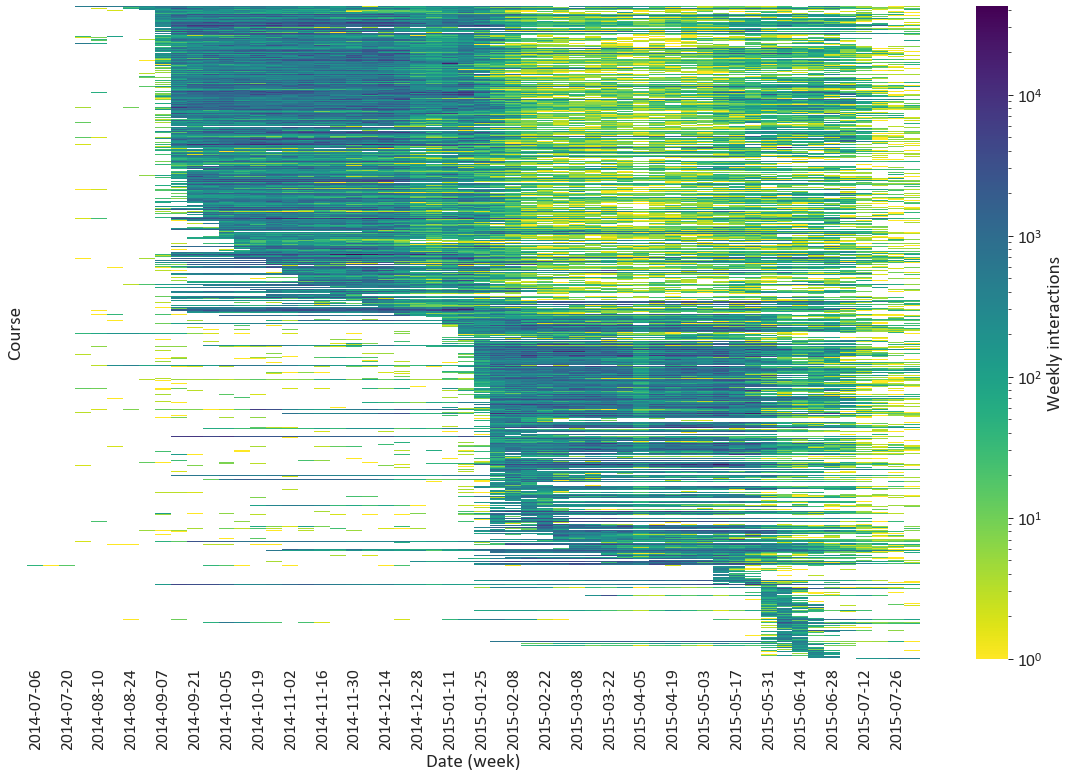

In [20]:
sns.set_theme(context='paper', style='whitegrid', font='Calibri', rc={"figure.figsize":(20, 12)}, font_scale=2)

#here, we are plotting the first
heat1 = sns.heatmap(grouped_data, robust=True, norm=LogNorm(), xticklabels = 2, yticklabels= False,
            cmap = standard_cmap, cbar_kws={'label': 'Weekly interactions'})

fig = heat1.get_figure()
fig.savefig('../Images/exploratory_course_weekly_clicks_heatmap.png', transparent=True, dpi=300)

#delete to remove from memory
del fig, heat1

**We can, additionally**, make some additional observations that may come in handy in the future:

a. How many students are attending each course,

b. How many courses is each student attending,

This knowledge will allow us make additional filtering decisions to enhance our sample.

In [21]:
#we can compute the number of students attending each course, and the number of courses each student is attending
class_list = student_courses.groupby('course')['userid'].count().to_frame().rename(columns = {'userid' : 'Users per course'})
enrollment_size = student_courses.groupby('userid')['course'].count().to_frame().rename(columns = {'course' : 'Courses per User'})

**A. How many students are attending each course?**

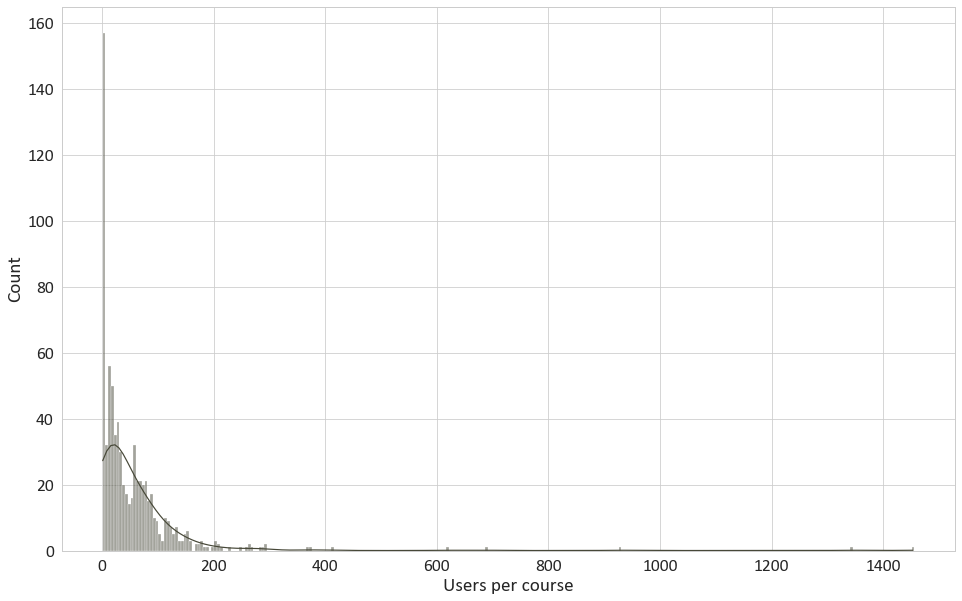

In [22]:
#settub
sns.set_theme(context='paper', style='whitegrid', font='Calibri', rc={"figure.figsize":(16, 10)}, font_scale=2)

#a number of students per course
#student_courses.rename(columns = {'userid' : 'Students per course'}, inplace = True)

#then we plot an histogram with all courses, we are not interested in keeping courses with a number of students inferior to 10
hist1 = sns.histplot(data=class_list, x='Users per course', kde=True, color= student_color, binwidth = 5,)

fig = hist1.get_figure()
fig.savefig('../Images/hist1_students_per_course_bin_5.png', transparent=True, dpi=300)

#delete to remove from memory
del fig, hist1

**There is a very significant number of courses with between 1 and 10 students**


**B. In how many courses is each student enrolled?**

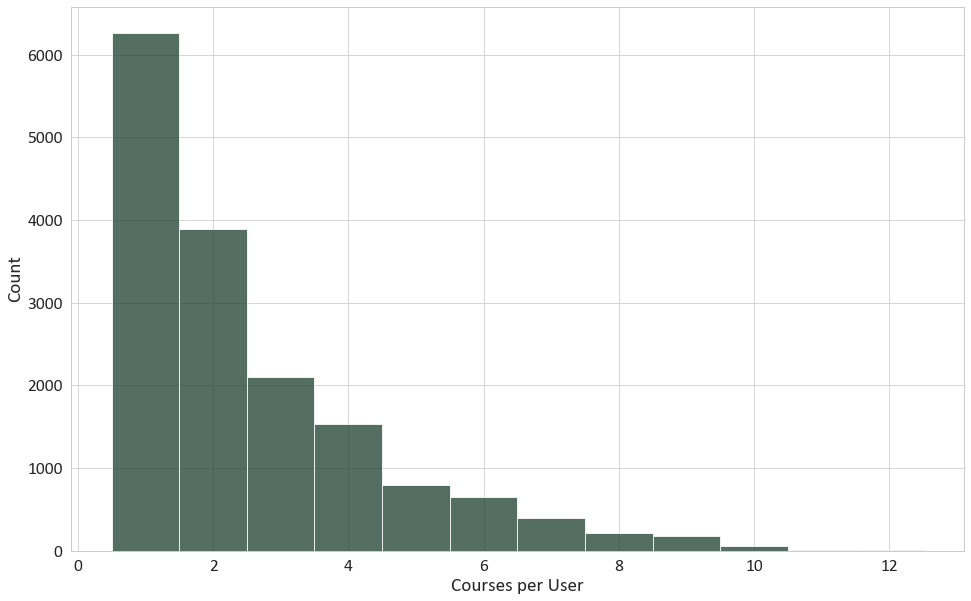

In [23]:
#then we plot an histogram with all courses, we are not interested in keeping courses with a number of students inferior to 10
hist2 = sns.histplot(data= enrollment_size, 
        x='Courses per User', color= course_color, discrete = True, fill = True)

fig = hist2.get_figure()
fig.savefig('../Images/hist2_courses_per_student course_bin_1.png', transparent=True, dpi=300)

#delete to remove from memory
del fig, hist2

Depending on the course in question, it is possible for it to have 1 registered user vs almost 1400.
Additionally, we can also see that there is a significant number of students attending a single course (over 6000).

To some extent, most courses have some degree of interaction no matter how small.

We can see that many of the interactions start in late August, early September - the start of the school year. 
When it comes to different disciplines we can also discern different the most common starting points:
- Early September
- End of January/Start of February

Additionally, many courses seem, at least on a preliminary level, be consistent with the split between semesters and trimesters.

### Goal 2: To estimate course end-date

Moodle provides the start date of each course. However, it does not provide an end-date. 
Course duration is, thus, an estimated value:

For each course, the authors look at the sequences of interactions, ignore any outlier dates (using the 1.5 * IQR rule) and set the end of course date as the date corresponding to the 95% percentile.

Again, as we do not have absolute knowledge over the course duration - we will blindly follow the instructions laid out by the authors.

For that, we will start by splitting the logs by course - for that we will create a dict of dfs: 

In [24]:
course_dict = {course: student_logs.loc[student_logs['course'] == course][['time']] for course in tqdm(course_array)}

  0%|          | 0/732 [00:00<?, ?it/s]

After getting the dictionary, we now have the ability to, for every course, repeat what was done by the authors of the Riestra González paper.

For that, we will create a function. We choose to do it this way because we can use the pipe method.

In [25]:
def get_end_date(logs):
    '''takes logs as input and performs multiple operations
    1 - sorts column with name time,
    2 - removes outlier dates - as defined as outsude the interval [1.5IQR - Q1, 1.5 IQR + Q3]
    3 - calculates the date of the 95th percentile of remaining logs,
    4 - returns date - assumed to be date of end of course'''    
     
    #step 1: sort logs
    logs = logs.sort_values(by = 'time').reset_index(drop = True)
    
    #step 2: remove outliers 
    # Computing IQR
    Q1 = logs['time'].quantile(0.25)
    Q3 = logs['time'].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 -(1.5 * IQR) 
    upper_bound = Q3 +(1.5 * IQR)
    # Filtering Values between Q1-1.5IQR and Q3+1.5IQR
    logs = logs[(logs['time'].between(lower_bound, upper_bound, inclusive=True))]
    #print(logs)
    
    #step 3: returns date corresponding to 95th percentile
    logs = logs['time'].quantile(0.95)
    #print(logs)
    
    return logs

In [26]:
course_dict = {course: course_dict[course].pipe(get_end_date) for course in tqdm(course_dict)}

  0%|          | 0/732 [00:00<?, ?it/s]

Now, we have a dict with can map store this date as a column. We will do that, but first, we will also create a column with the start date. For both, we will use the dictionaries we created with both start date and our estimated end date. 

In [27]:
#start date
class_list['Start Date'] = class_list.index.to_series().map(sorting_hat)

#end date
class_list['End Date'] = class_list.index.to_series().map(course_dict)

#additionally, we will look at our estimated course duration
class_list['Course duration days'] = class_list['End Date'] - class_list['Start Date']

Before finishing, we will take an additional look at our list of courses their duration.

In situations where the course duration is very small we may disconsider them outright. Courses at NOVA IMS will be either annual, semestral or trimestral. For that, we will add the following criteria for exclusion:

1. Start Date occurs before 24th of August 2014 - our threshold.
2. Courses with a small duration (below 4 weeks)

In [28]:
#1 Filter by Start Date - we lose 3 courses
class_list = class_list[class_list['Start Date'] >= '24-08-2014']

#filtering all courses with duration equal to or below 1 week
small_duration = class_list[class_list['Course duration days'] <= pd.to_timedelta(4, unit = 'W')].sort_values(by = 'Course duration days').reset_index()
class_list = class_list[~class_list.index.isin(small_duration['course'])]

#we can now filter our student logs, hereby removing all of these unnecessary courses
student_logs = student_logs[student_logs['course'].isin(class_list.index)]

In [29]:
class_list

,Users per course,Start Date,End Date,Course duration days
course,,,,
1000.0,16,2014-08-31 22:00:00,2015-01-19 18:14:57.949999872,140 days 20:14:57.949999872
1002.0,22,2014-09-28 22:00:00,2015-03-04 09:08:48.800000000,156 days 11:08:48.800000
1010.0,58,2014-09-11 22:00:00,2014-12-22 09:07:01.200000000,101 days 11:07:01.200000
1013.0,76,2014-09-23 22:00:00,2015-02-02 09:58:50.000000000,131 days 11:58:50
1020.0,72,2015-01-11 23:00:00,2015-06-04 17:38:06.100000000,143 days 18:38:06.100000
...,...,...,...,...
984.0,14,2014-08-31 22:00:00,2015-01-27 17:20:00.750000128,148 days 19:20:00.750000128
985.0,22,2014-08-24 22:00:00,2015-02-25 07:31:20.900000000,184 days 09:31:20.900000
992.0,17,2015-02-09 23:00:00,2015-05-12 08:20:18.500000000,91 days 09:20:18.500000


In [30]:
student_logs

,id,time,userid,ip,course,module,cmid,action,url,info
0,1673.0,2014-07-01 13:30:43,4.0,127.0.0.1,5017.0,course,0.0,view,view.php?id=5017,5017
1,1674.0,2014-07-01 13:30:46,4.0,127.0.0.1,5017.0,assign,201698.0,view,view.php?id=201698,Ver página de estado de las entregas propios.
2,1675.0,2014-07-01 13:30:49,4.0,127.0.0.1,5017.0,assign,201698.0,view submit assignment form,view.php?id=201698,Ver la página propia de entregas a tareas.
3,1677.0,2014-07-01 13:31:02,4.0,127.0.0.1,5017.0,assign,201698.0,view,view.php?id=201698,Ver página de estado de las entregas propios.
4,1676.0,2014-07-01 13:31:02,4.0,127.0.0.1,5017.0,assign,201698.0,submit,view.php?id=201698,Estado de la entrega: Borrador (no enviado). <...
...,...,...,...,...,...,...,...,...,...,...
9637408,47116784.0,2015-07-31 03:00:07,20151.0,127.0.0.1,1376.0,resource,56623.0,view,view.php?id=56623,36375
9637409,47116785.0,2015-07-31 03:00:08,20151.0,127.0.0.1,1376.0,resource,56621.0,view,view.php?id=56621,36374
9637410,47116786.0,2015-07-31 03:00:09,20151.0,127.0.0.1,1376.0,resource,56620.0,view,view.php?id=56620,36373
9637411,47116787.0,2015-07-31 03:00:10,20151.0,127.0.0.1,1376.0,resource,56619.0,view,view.php?id=56619,36372


We note that many of the disciplines discarded have, in practice, logs that are consistent with the theoretical very small duration of the course. 

It is, nonetheless important to highlight the existence of courses whose log existence would not be consistent with the calculated duration. After verification, we found that, while the End-date was consistent with the logs, the start date was not.

In these instances, we opted to remove the courses as there is no way to confirm the exact start date.

In [31]:
#additional manipulations required to plot interactions
small_duration['course'] = pd.to_numeric(small_duration['course']).astype(int)

#finally we create the pivot_table that we will use to create our heatmap
small_duration = small_duration.set_index('course', drop = True)

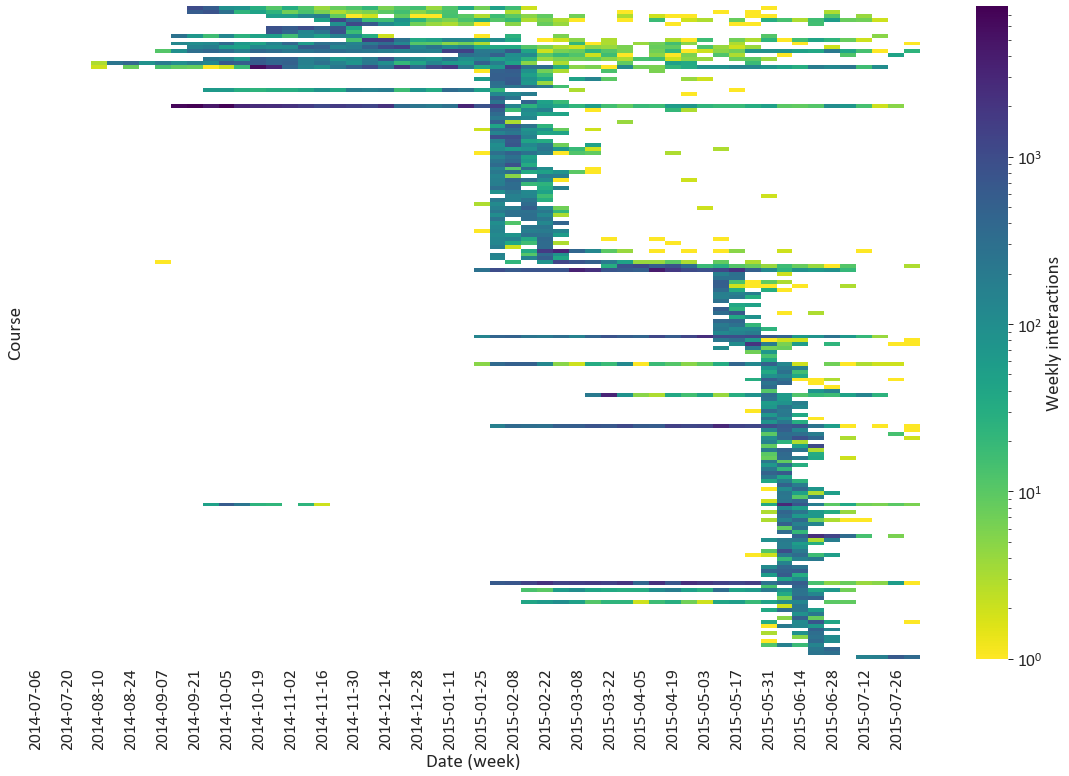

In [32]:
sns.set_theme(context='paper', style='whitegrid', font='Calibri', rc={"figure.figsize":(20, 12)}, font_scale=2)

#here, we are plotting the first
heat2 = sns.heatmap(grouped_data[grouped_data.index.isin(small_duration.index.to_list())], robust=True, norm=LogNorm(), xticklabels = 2, yticklabels= False,
            cmap = standard_cmap, cbar_kws={'label': 'Weekly interactions'})

fig = heat2.get_figure()
fig.savefig('../Images/weekly_clicks_small_duration_heatmap.png', transparent=True, dpi=300)

#delete to remove from memory
del fig, heat2

**Now, we will fininsh our work by removing all logs outside the following conditions.**

We will build 2 cutoff points:

1. One week before the start date of the course, 
2. After the perceived end of course.

In [33]:
#a new look into class list
class_list['cuttoff_point'] = pd.to_datetime((class_list['Start Date'] - pd.to_timedelta(1.1, unit = 'W')).dt.date)

#convert to date
class_list['Start Date'] = pd.to_datetime(class_list['Start Date'].dt.date)
class_list['End Date'] = pd.to_datetime(class_list['End Date'].dt.date)
class_list['Course duration days'] = class_list['End Date'] - class_list['Start Date']
class_list.reset_index(inplace = True)

#we will create a new dict with the start date
cuttoff_point = class_list.set_index('course').to_dict()['cuttoff_point'] 

#we'll create a new column that will signal whether we are whithin our course boundaries or not
student_logs['start_bound'] = student_logs['course'].map(cuttoff_point)
student_logs['end_bound'] = student_logs['course'].map(course_dict)

#convert to date
student_logs['start_bound'] = pd.to_datetime(student_logs['start_bound'].dt.date)
student_logs['end_bound'] = pd.to_datetime(student_logs['end_bound'].dt.date)

**Now, we only keep rows that are inside between the dates inside the start and end bounds.**

In [34]:
student_logs = student_logs[student_logs['time'].between(student_logs['start_bound'], student_logs['end_bound'], inclusive = True)].reset_index(drop = True)
student_logs

,id,time,userid,ip,course,module,cmid,action,url,info,start_bound,end_bound
0,262124.0,2014-08-25 12:03:21,68582.0,127.0.0.1,985.0,course,0.0,view,view.php?id=985,985,2014-08-17,2015-02-25
1,262137.0,2014-08-25 12:04:40,68582.0,127.0.0.1,985.0,folder,35183.0,view,view.php?id=35183,680,2014-08-17,2015-02-25
2,262161.0,2014-08-25 12:07:37,68582.0,127.0.0.1,985.0,course,0.0,view,view.php?id=985,985,2014-08-17,2015-02-25
3,262162.0,2014-08-25 12:07:43,68582.0,127.0.0.1,985.0,folder,35189.0,view,view.php?id=35189,685,2014-08-17,2015-02-25
4,268473.0,2014-08-26 10:23:43,68582.0,127.0.0.1,985.0,course,0.0,view,view.php?id=985,985,2014-08-17,2015-02-25
...,...,...,...,...,...,...,...,...,...,...,...,...
7886985,46941392.0,2015-07-09 09:06:31,78085.0,127.0.0.1,4873.0,course,0.0,view,view.php?id=4873,4873,2015-05-24,2015-07-10
7886986,46941411.0,2015-07-09 09:06:50,78085.0,127.0.0.1,4873.0,course,0.0,recent,recent.php?id=4873,4873,2015-05-24,2015-07-10
7886987,46941443.0,2015-07-09 09:08:09,78085.0,127.0.0.1,4873.0,forum,273852.0,view forum,view.php?id=273852,9459,2015-05-24,2015-07-10
7886988,46944179.0,2015-07-09 10:56:34,5356.0,127.0.0.1,4873.0,course,0.0,view,view.php?id=4873,4873,2015-05-24,2015-07-10


**After finishing, we will now take a new look at the weekly interactions.**

We are expecting a cleaner view at the weekly interactions performed by students in the context of their courses.

In [35]:
#Then, when it comes to logs, we aggregate by week
grouped_data = student_logs.groupby([pd.Grouper(key='time', freq='W'), 'course']).agg({
                                                                             'action': 'count',
                                                                             }).reset_index().sort_values('time')
#change for better reading
grouped_data['Date (week)'] = grouped_data['time'].astype(str)

#creating pivot table to create heatmap
grouped_data = grouped_data.pivot_table(index ='course', 
                       columns = 'Date (week)',
                        values = 'action', 
                       aggfunc =np.sum,
                        fill_value=np.nan).reset_index().rename(columns = {'course' : 'Course'})

#now, we will sort the courses according to the starting date
grouped_data['sort'] = grouped_data['Course'].map(sorting_hat)
grouped_data['Course'] = pd.to_numeric(grouped_data['Course']).astype(int)

#finally we create the pivot_table that we will use to create our heatmap
grouped_data = grouped_data.set_index('Course', drop = True).sort_values('sort').drop('sort', axis = 1)
grouped_data.T.describe(include = 'all').T

,count,mean,std,min,25%,50%,75%,max
Course,,,,,,,,
985,27.0,166.962963,117.494184,43.0,97.00,124.0,198.00,505.0
1000,20.0,151.800000,127.440636,4.0,53.25,140.5,209.75,447.0
3101,19.0,528.578947,291.337970,24.0,367.50,494.0,643.00,1051.0
380,20.0,125.750000,125.808072,1.0,19.50,96.0,180.50,460.0
412,17.0,113.411765,91.407781,36.0,59.00,86.0,113.00,388.0
...,...,...,...,...,...,...,...,...
3029,8.0,2527.250000,3125.613803,130.0,782.50,1596.5,2679.25,9852.0
5688,5.0,2180.000000,1809.007739,195.0,836.00,1833.0,3535.00,4501.0
4635,7.0,125.285714,196.711052,12.0,23.50,49.0,104.50,560.0


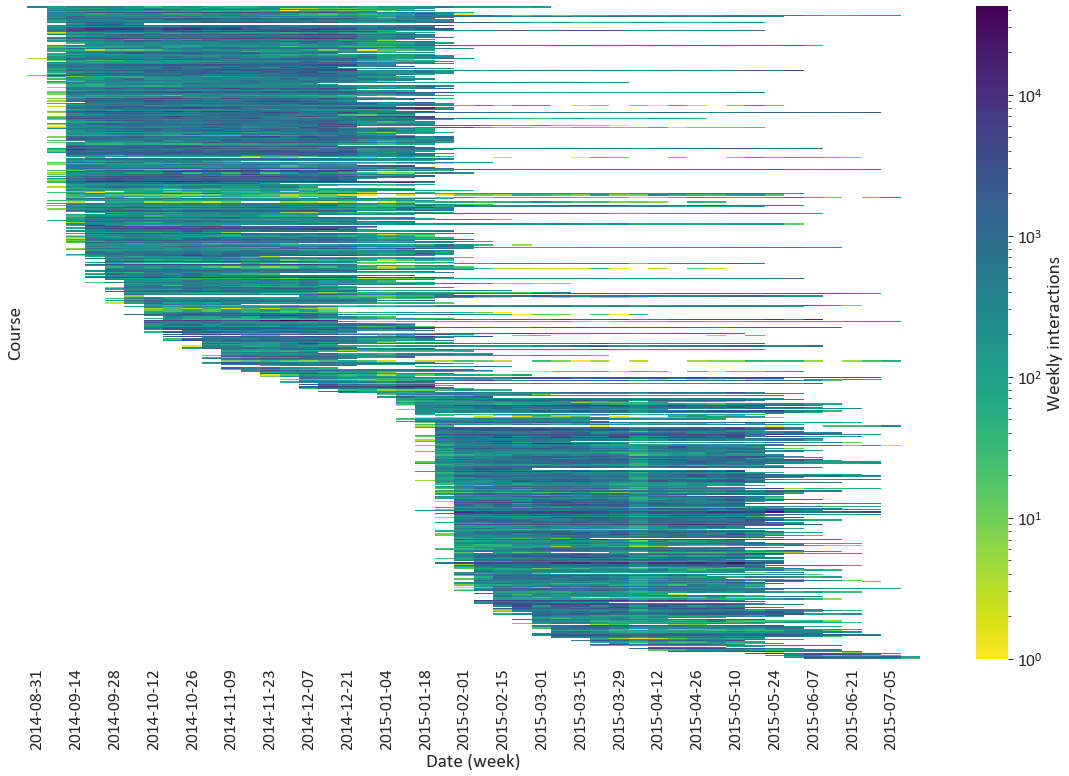

In [36]:
#here, we are plotting the nex
heat3 = sns.heatmap(grouped_data, robust=True, norm=LogNorm(), xticklabels = 2, yticklabels= False,
            cmap = standard_cmap, cbar_kws={'label': 'Weekly interactions'})

fig = heat3.get_figure()
fig.savefig('../Images/cleaned_weekly_clicks_heat3.png', transparent=True, dpi=300)

#delete to remove from memory
del fig, heat3

We finish the notebook by saving the cleaned logs and the list of the courses with which we will be going forward in our analysis. 

A very important factor to take into account is the fact that, as our targets, we will only have access to the student-pairt courses that we were able to identify in our targets table - which are the same as the ones present iin our support_table.

It is, therefore, wise to perform a last filtering step before going forward.

In [37]:
#get all unique student course pairs present in the support table
support_table = support_table[['courseid', 'userid']].drop_duplicates().rename(columns = {'courseid': 'course'})

#merge with our current, cleaned, logs - will only include courses that we have not expressly excluded thus far
student_logs = student_logs.merge(support_table, on = ['course','userid'], how = 'inner').reset_index(drop = True)

In [38]:
student_logs

,id,time,userid,ip,course,module,cmid,action,url,info,start_bound,end_bound
0,262124.0,2014-08-25 12:03:21,68582.0,127.0.0.1,985.0,course,0.0,view,view.php?id=985,985,2014-08-17,2015-02-25
1,262137.0,2014-08-25 12:04:40,68582.0,127.0.0.1,985.0,folder,35183.0,view,view.php?id=35183,680,2014-08-17,2015-02-25
2,262161.0,2014-08-25 12:07:37,68582.0,127.0.0.1,985.0,course,0.0,view,view.php?id=985,985,2014-08-17,2015-02-25
3,262162.0,2014-08-25 12:07:43,68582.0,127.0.0.1,985.0,folder,35189.0,view,view.php?id=35189,685,2014-08-17,2015-02-25
4,268473.0,2014-08-26 10:23:43,68582.0,127.0.0.1,985.0,course,0.0,view,view.php?id=985,985,2014-08-17,2015-02-25
...,...,...,...,...,...,...,...,...,...,...,...,...
6869426,46109453.0,2015-06-22 08:39:09,77225.0,127.0.0.1,5688.0,forum,0.0,view forums,index.php?id=5688,NaN,2015-05-18,2015-06-26
6869427,46287163.0,2015-06-24 08:35:37,77225.0,127.0.0.1,5688.0,course,0.0,view,view.php?id=5688,5688,2015-05-18,2015-06-26
6869428,45940294.0,2015-06-18 08:57:58,52262.0,127.0.0.1,2411.0,course,0.0,view,view.php?id=2411,2411,2015-01-12,2015-06-23
6869429,45940340.0,2015-06-18 08:58:35,52262.0,127.0.0.1,2411.0,resource,105562.0,view,view.php?id=105562,68316,2015-01-12,2015-06-23


And finally, we will update the student per course count presented in the final logs: This will ensure that we are working with the most up-to-date information.

In [39]:
#We start by updating the relevant student_course list
student_courses = student_logs.filter(['course', 'userid']).drop_duplicates().reset_index(drop = True)

#then, we compute the updated number of students attending each course
new_class_list = student_courses.groupby('course')['userid'].count().to_frame().rename(columns = {'userid' : 'Users per course'}).reset_index()

#we will create a new dict with the start date
new_class_list = new_class_list.set_index('course').to_dict()['Users per course']

#we'll create a new column that will signal whether we are whithin our course boundaries or not
class_list['Users per course'] = np.where(class_list['course'].isin(new_class_list.keys()),
                                          class_list['course'].map(new_class_list).astype(int),
                                          np.nan)

In [40]:
class_list['Course duration days'] = (class_list['Course duration days'].dt.total_seconds() // 3600 // 24) + 1

In [41]:
class_list

,course,Users per course,Start Date,End Date,Course duration days,cuttoff_point
0,1000.0,12.0,2014-08-31,2015-01-19,142.0,2014-08-24
1,1002.0,22.0,2014-09-28,2015-03-04,158.0,2014-09-21
2,1010.0,48.0,2014-09-11,2014-12-22,103.0,2014-09-04
3,1013.0,71.0,2014-09-23,2015-02-02,133.0,2014-09-16
4,1020.0,64.0,2015-01-11,2015-06-04,145.0,2015-01-04
...,...,...,...,...,...,...
557,984.0,13.0,2014-08-31,2015-01-27,150.0,2014-08-24
558,985.0,22.0,2014-08-24,2015-02-25,186.0,2014-08-17
559,992.0,16.0,2015-02-09,2015-05-12,93.0,2015-02-02
560,993.0,55.0,2014-09-11,2015-01-12,124.0,2014-09-04


In [42]:
#save tables 
class_list.to_csv('../Data/Modeling Stage/R_Gonz_class_duration.csv') 

student_logs.drop(['start_bound', 'end_bound'], axis = 1).to_csv('../Data/Modeling Stage/R_Gonz_cleaned_logs.csv')

#### Done

From here on out, we will continue with feature engineering and extraction for modeling purposes in Notebooks 3.